# Анализ картинок

Создайте эмбеддинги изображений и отобразите их в tensorboard projector'е

1. Скачайте датасет [CelebA](https://pytorch.org/vision/stable/datasets.html#celeba) или любой другой не рассмотренный на лекции
1. Выберите одну из предобученных [моделей torchvision](https://pytorch.org/vision/stable/models.html)
1. Создайте эмбеддинги изображений из датасета
1. Визуализируйте эмбеддинги в tensorboard projector

In [1]:
import random
import numpy as np

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import SVHN
from torch.utils.data import DataLoader
from torchvision.models import mobilenet_v3_small

from tqdm.notebook import tqdm, trange

import matplotlib.pyplot as plt

# Фиксируем random seed для воспроизводимости результатов
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True


OUTPUT_DIM = 10  # Количество классов
EPOCH_NUM = 4  # Сколько эпох будет обучать модель

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
basic_transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomCrop(32),
    transforms.ToTensor()
])  # Базовые аугментации для тренировочных данных (грубо говоря бесплатное увеличение тренировочной выборки)

In [3]:
# Загрузим данные
train_dataset = SVHN(
    root='./data/SVHN', 
    split='train',    
    transform=basic_transform,
    download=True
)

test_dataset = SVHN(
    root='./data/SVHN',
    split='test', 
    transform=transforms.ToTensor(),  # Для тестовых данные НЕ НАДО использовать нгикакие аугментации
    download=True
)

Using downloaded and verified file: ./data/SVHN\train_32x32.mat
Using downloaded and verified file: ./data/SVHN\test_32x32.mat


In [4]:
# Создадим DataLoader'ы (для того чтобы было проще итерироваться)

dataloaders = {
    'train': DataLoader(
        dataset=train_dataset,
        batch_size=128, 
        shuffle=True
    ),
    'val': DataLoader(
        dataset=test_dataset,
        batch_size=128, 
        shuffle=False
    )
}

In [5]:
# Создадим класс нашей модели

# Так как мы хотим использовать все фишки библиотеки Pytorch важно наследоваться от nn.Module
class Classifier(nn.Module):
    def __init__(self, ouput_dim):
        super(Classifier, self).__init__()  # "Регистрируем" создаваемый объект как нейросетевую модель
        self.model = mobilenet_v3_small(pretrained=True)  # Скачиваем пред-обученную основу для нашей модели
        
        # "Замораживаем" все веса для ускорения обучения (мы считаем что они уже хорошо обучены)
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Создаем "голову" которую мы и будем обучать
        self.fc1 = nn.Sequential(
            nn.Linear(1000, 64),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(64, ouput_dim)
        )
    
    def embed(self, x):
        return self.fc1(self.model(x))
    
    # Описываем как именно наша модель будет генерировать предсказания
    def forward(self, x):
        resnet_out = self.embed(x)
        return self.fc2(resnet_out)

In [6]:
model = Classifier(OUTPUT_DIM)
model = model.to(DEVICE)  # Переносим модель на GPU

In [7]:
# Создаем функцию ошибки (так как задача многоклассовой классификации, то используем кросс-энтропию)
# Более подробно об этом будет в курсе машинного обучения
loss_function = torch.nn.CrossEntropyLoss()

# Регистрируем для нашей модели способ изменения её весов
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-4)

In [8]:
loss_hist = {'train': [], 'val': []}
acc_hist = {'train': [], 'val': []}

# Важно! В данном примере точность используется для упрощения.
# Никогда не используйте её если у вас несбалансированная выборка
# Возьмите лучше F_score или ROC_AUC (об этом вам потом расскажут)

# Основной алгоритм обучения
for epoch in trange(EPOCH_NUM, desc='Whole pipeline'):
    
    for phase in ['train', 'val']:
        dataloader = dataloaders[phase]
        
        # Это условие необходимо так как у нас есть слой DropOut
        # И на валидации его принято фиксировать
        if phase == 'train':
            model.train() 
        elif phase == 'val':
            model.eval()
        
        running_loss = 0.
        running_acc = 0.
        
        # Проходимся по набору данных
        for (X_batch, y_batch) in tqdm(dataloader, desc=f'Epoch: {epoch + 1}. Phase: {phase}'):
            # Нормализуем наши данные
            X_batch = X_batch / 255
            X_batch = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(X_batch)
            
            # Переносим на устройство
            X_batch = X_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            
            # Для корректного обучения перед каждым шагом необходимо сбрасывать прошлые ошибки
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase == 'train'):
                y_pred = model(X_batch)
                
                loss_value = loss_function(y_pred, y_batch)
                y_pred_class = y_pred.argmax(dim=1)
                
                # На обучении мы хотим учиться в зависимости от ошибки
                if phase == 'train':
                    loss_value.backward()
                    optimizer.step()
                   
            # Аггрегируем ошибку и точность
            running_loss += loss_value.item()
            running_acc += (y_pred_class == y_batch.data).float().mean().data.cpu().numpy()
        
        epoch_loss = running_loss / len(dataloader)
        epoch_acc = running_acc / len(dataloader)
        
        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} ', end='')
        
        loss_hist[phase].append(epoch_loss)
        acc_hist[phase].append(epoch_acc)

Whole pipeline:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1. Phase: train:   0%|          | 0/573 [00:00<?, ?it/s]

train Loss: 2.3528 Acc: 0.1449 

Epoch: 1. Phase: val:   0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 2.2885 Acc: 0.1959 

Epoch: 2. Phase: train:   0%|          | 0/573 [00:00<?, ?it/s]

train Loss: 2.2835 Acc: 0.1888 

Epoch: 2. Phase: val:   0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 2.2768 Acc: 0.1957 

Epoch: 3. Phase: train:   0%|          | 0/573 [00:00<?, ?it/s]

train Loss: 2.2672 Acc: 0.1890 

Epoch: 3. Phase: val:   0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 2.2438 Acc: 0.1960 

Epoch: 4. Phase: train:   0%|          | 0/573 [00:00<?, ?it/s]

train Loss: 2.2521 Acc: 0.1892 

Epoch: 4. Phase: val:   0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 2.2338 Acc: 0.1959 

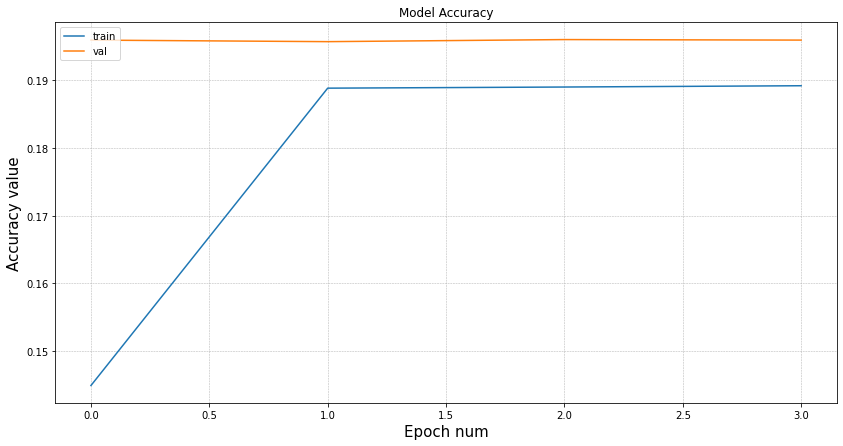

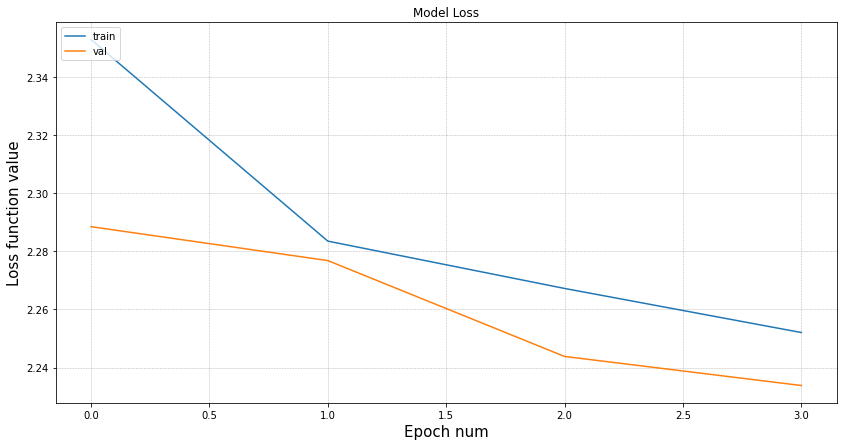

In [9]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in acc_hist.keys():
    plt.plot(acc_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')
plt.show()

plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in loss_hist.keys():
    plt.plot(loss_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss function value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')
plt.show()

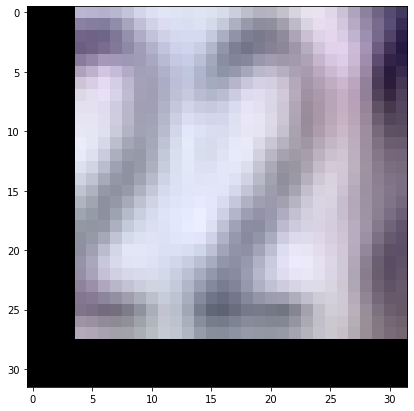

In [10]:
img = train_dataset[40][0].detach().numpy()

plt.imshow(np.transpose(img, (1,2,0)))

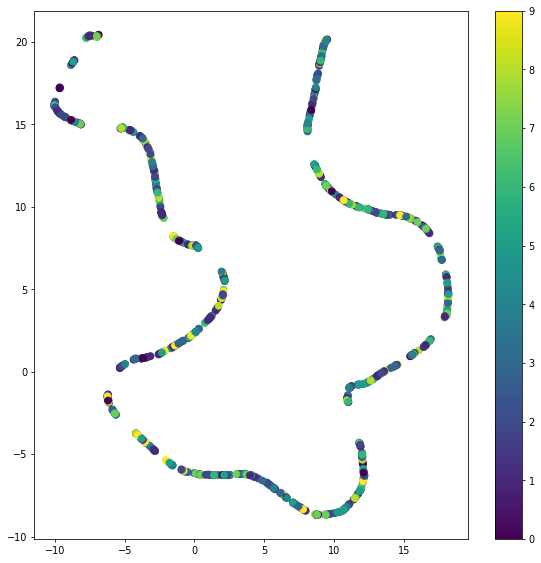

In [34]:
import umap.umap_ as umap

train_items = [train_dataset[i] for i in range(1000)]
xs, ys = zip(*train_items)

xs = torch.stack(xs)
xs = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(xs)

embs = model.embed(xs)

points = umap.UMAP().fit_transform(embs.detach().numpy())

plt.figure(figsize=(10, 10), dpi=70)
plt.scatter(points[:, 0], points[:, 1], c=ys, s=50)
plt.colorbar()
plt.show()

In [30]:
from tensorboardX import SummaryWriter

writer = SummaryWriter()

# log embeddings
features = xs.mean(dim=1).view(-1, 32 * 32)
writer.add_embedding(features,
                     metadata=ys,
                     label_img=xs)
writer.close()

In [31]:
! powershell "echo 'checking for existing tensorboard processes'"
! powershell "ps | Where-Object {$_.ProcessName -eq 'tensorboard'}"

! powershell "ps | Where-Object {$_.ProcessName -eq 'tensorboard'}| %{kill $_}"

! powershell "echo 'cleaning tensorboard temp dir'"
! powershell "rm $env:TEMP\.tensorboard-info\*"

! powershell "ps | Where-Object {$_.ProcessName -eq 'tensorboard'}"

checking for existing tensorboard processes

Handles  NPM(K)    PM(K)      WS(K)     CPU(s)     Id  SI ProcessName                                                  
-------  ------    -----      -----     ------     --  -- -----------                                                  
     52       5      808       3444       0,02   4832   1 tensorboard                                                  


cleaning tensorboard temp dir


In [32]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

In [33]:
%tensorboard --logdir="C:\Users\Vlad\opencv\Scripts\DataAn\Lab6\runs" --host=127.0.0.1

# Лена

Примените фильтр к изображению Лены

1. Скачайте изображение [Лены](http://optipng.sourceforge.net/pngtech/img/lena.png)
1. Найдите фильтр для выделения признака на изображении. В лекции показан пример фильтра Собеля. Использовать примеры с лекций нельзя. Начать поиск фильтра можно с [этой страницы](https://en.wikipedia.org/wiki/Feature_(computer_vision)#Extraction)
1. Реализуйте процедуру свёртки изображения с фильтром
1. Сверните Лену

In [15]:
from platform import python_version
import cv2
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

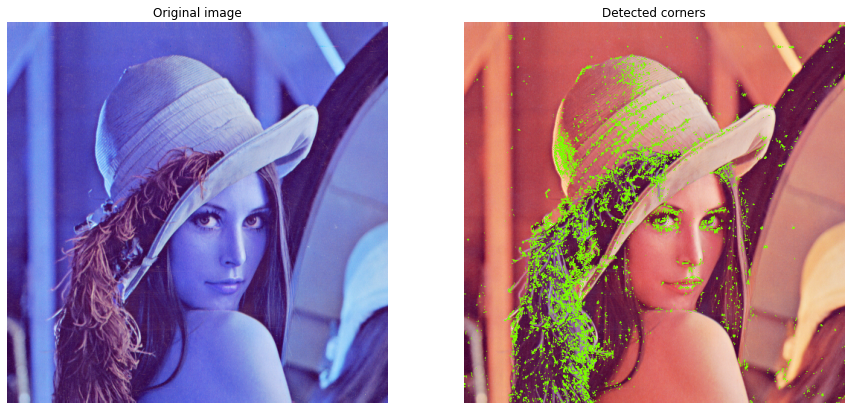

In [16]:
img_brg = cv2.imread('data/lena.png') 
img = cv2.cvtColor(img_brg, cv2.COLOR_BGR2RGB)  

gray = np.float32(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

dst = cv2.cornerHarris(gray,2,3,0.04)

# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.0001*dst.max()]=[124,252,0]

plt.figure(figsize=(15, 10))

ax = plt.subplot(121)
ax.set_title('Original image')
ax.axis('off')
ax.imshow(img_brg)

ax = plt.subplot(122)
ax.set_title('Detected corners')
ax.axis('off')
ax.imshow(img, cmap='gray');

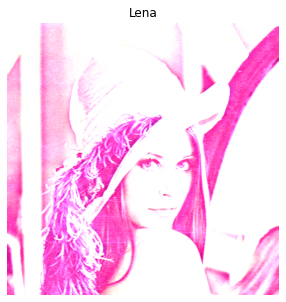

In [17]:
img = cv2.cvtColor(cv2.imread('data/lena.png'), cv2.COLOR_BGR2RGB) 

kernel = np.array([[0.0, -1.0, 0.0], 
                   [-1.0, 4.0, -1.0],
                   [0.0, -1.0, 0.0]])
kernel = kernel/sum(kernel)

img_rst = cv2.filter2D(img,-1,kernel)

plt.figure(figsize=(15, 5))
plt.title('Lena')
plt.imshow(img_rst)
plt.axis('off')
plt.show()